# Biliotecas

In [1]:
# Instala os pacotes necessários:
# - gymnasium[toy-text]: inclui ambientes simples como FrozenLake, Taxi, etc.
# - imageio[ffmpeg]: permite salvar vídeos e GIFs (formato .mp4 ou .gif)
#pip install gymnasium[toy-text] imageio[ffmpeg]

In [2]:
# Importa as bibliotecas principais
import gymnasium as gym               # Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm            # barra de progresso
print(gym.__version__)

1.1.1


/home/daniel/ufrn/ref-learning/rl-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Implementação do Q-learning

In [22]:
def executar_episodio_guloso(
    env: gym.Env,                 # ambiente já instanciado
    Q: np.ndarray,                # tabela Q (shape: |S| × |A|)
    max_steps: int = 1_000        # limite de passos por segurança
) -> Tuple[float, int]:
    """
    Executa 1 episódio usando política determinística gulosa (ação = argmax_a Q(s,a)) e devolve a recompensa acumulada e o número de passos.
    O laço termina se ocorrer qualquer destas condições:
    1. `terminated`  – objetivo alcançado, segundo o ambiente.
    2. `truncated`   – limite de passos imposto por `TimeLimit`.
    3. Queda no penhasco (`reward == -100`), caso específico do Cliff Walking.
    4. Número de passos ≥ `max_steps`.
    """
    s, _ = env.reset()            # estado inicial
    ret: float = 0.0              # recompensa acumulada
    steps: int = 0                # contador de passos

    # laço limitado a `max_steps`
    for _ in range(max_steps):
        a: int = int(np.argmax(Q[s]))          # ação gulosa
        s, r, term, trunc, _ = env.step(a)     # transição ambiente
        ret   += float(r)                      # acumula recompensa
        steps += 1                             # incrementa passo

        cliff: bool = (r == -100)              # caiu no precipício? (ambiente Cliff Walking)
        if term or trunc or cliff:             # condição de parada
            break

    return ret, steps


def q_learning(
    env: gym.Env,                 # ambiente Gymnasium
    episodes: int,                # número total de episódios
    alpha: float,                 # taxa de aprendizado (passo do gradiente TD)
    gamma: float,                 # fator de desconto
    epsilon: float                # epsilon fixo da política comportamental
) -> Tuple[np.ndarray,
           List[int],
           List[float],
           Dict[int, np.ndarray]]:
    """
    Retorna
    -------
    q_table          : np.ndarray           – matriz |S| × |A| com valores Q
    episodio_len     : list[int]            – número de passos dos episódio
    episodio_return  : list[float]          – retorno total dos episódio
    target_policy    : dict[int, np.ndarray]– política determinística gulosa final
    """

    # Inicializa a tabela Q com zeros
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    
    # Listas para armazenar métricas de avaliação
    episodio_len = []
    episodio_return = []
    
    # Loop principal do Q-learning
    for episode in range(episodes):
        # Reinicia o ambiente
        state, _ = env.reset()
        
        # Executa um episódio completo usando epsilon-greedy para treinamento
        for step in range(1000):  # limite de passos para evitar loops infinitos
            # Política epsilon-greedy: exploração vs exploração
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # ação aleatória (exploração)
            else:
                action = np.argmax(q_table[state])  # ação gulosa (exploração)
            
            # Executa a ação no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Atualização Q-learning: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
            best_next_action = np.argmax(q_table[next_state])
            q_table[state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[state, action]
            )
            
            # Atualiza o estado atual
            state = next_state
            
            # Verifica condições de parada
            if terminated or truncated or reward == -100:  # caiu no precipício (Cliff Walking)
                break
        
        # Avalia a política gulosa atual ao final de cada episódio
        ret, steps = executar_episodio_guloso(env=env, Q=q_table)
        episodio_len.append(steps)
        episodio_return.append(ret)
    
    # Constrói a política determinística gulosa final
    target_policy = {}
    for s in range(n_states):
        # Política gulosa: probabilidade 1 para a melhor ação, 0 para as demais
        policy_vector = np.zeros(n_actions)
        best_action = np.argmax(q_table[s])
        policy_vector[best_action] = 1.0
        target_policy[s] = policy_vector
    
    return q_table, episodio_len, episodio_return, target_policy

# Visualização

In [23]:
def plotar_metricas(
    episodio_len: list[int],          # lista com o número de passos de cada episódio
    episodio_return: list[float],     # lista com a recompensa total de cada episódio
    janela: int = 100                 # tamanho da janela da média móvel
) -> None:
    # Plot duração do episódio por episódio e a recompensa total por episodio.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodio_len, label='Comprimento do Episódio', color='blue')
    plt.xlabel('Episódio')
    plt.ylabel('Comprimento')
    plt.title('Comprimento do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(episodio_return, label='Retorno do Episódio', color='green')
    plt.xlabel('Episódio')
    plt.ylabel('Retorno')
    plt.title('Retorno do Episódio ao Longo do Tempo')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
ARROWS = {
    "FrozenLake-v1":  ['←', '↓', '→', '↑'],  # 0=Left, 1=Down, 2=Right, 3=Up
    "CliffWalking-v0": ['↑', '→', '↓', '←']  # 0=Up,   1=Right, 2=Down,  3=Left
}

def visualizar_politica(
    env,
    politica: Dict[int, np.ndarray],    # mapeamento estado → vetor de probabilidades (|A|)
    shape: tuple[int, int]              # (linhas, colunas) da grade
) -> None:
    """
    Desenha, com Matplotlib, histogramas das distribuições de probabilidade
    de cada ação em cada estado de um ambiente toy-text do gymnasium.

    Parâmetros
    ----------
    env : gymnasium.Env
        Ambiente já instanciado.
    politica : Dict[int, np.ndarray]
        Dicionário onde cada chave é um inteiro de estado e cada valor é um vetor 1-D com a distribuição epsilon-gulosa (ou gulosa) sobre as ações.
    shape : tuple[int, int]
        Formato da grade (número de linhas, número de colunas) para montagem dos subgráficos.
    """
    # Descobre o id do ambiente original
    id_env: str = env.unwrapped.spec.id

    # Seleciona os rótulos de setas apropriados
    try:
        direcoes: list[str] = ARROWS[id_env]
    except KeyError:                     # ambiente não mapeado
        raise ValueError(f"Ambiente “{id_env}” não suportado.")

    # Número de ações
    n_acoes: int = len(direcoes)
    acoes: np.ndarray = np.arange(n_acoes)  # [0, 1, 2, 3]

    # Cria grid de subplots: uma subplot por estado
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(3 * shape[1], 2.2 * shape[0]))
    axs = axs.flatten()  # facilita indexação linear

    # Percorre cada estado existente na política
    for s, ax in enumerate(axs):
        pi: np.ndarray = politica[s]            # vetor de probabilidades

        # Desenha barra com a probabilidade de cada ação
        ax.bar(acoes, pi, color='gray')

        # Configurações do eixo x
        ax.set_xticks(acoes)
        ax.set_xticklabels(direcoes)

        # Limites e ticks do eixo y
        ax.set_ylim(0, 1.05)
        ax.set_yticks([0, 0.5, 1])

        # Título identifica o número do estado
        ax.set_title(f"Estado {s}")

    # Ajusta layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

In [25]:
def gerar_gif(
    politica: Dict[int, np.ndarray],             # estado → distribuição sobre ações
    env: gym.Env,                                # ambiente com render_mode='rgb_array'
    path_gif: str,                               # caminho/arquivo de saída (.gif)
    n_episodios: int = 5                         # quantos episódios filmar
) -> str:
    """
    Executa `n_episodios` usando a política fornecida (epsilon-gulosa ou gulosa) e gera um GIF mostrando a trajetória do agente.

    Parâmetros
    ----------
    politica : Dict[int, np.ndarray]
        Para cada estado `s`, deve conter um vetor 1-D com as probabilidades de selecionar cada ação `a`.
    env : gymnasium.Env
        Ambiente já instanciado com `render_mode='rgb_array'`, pois `env.render()` retornará frames numéricos (arrays de pixels).
    path_gif : str
        Caminho completo do arquivo a ser salvo (ex.: `"trajetoria.gif"`).
    n_episodios : int, opcional (default=5)
        Número de episódios que serão simulados/gravados.

    Retorno
    -------
    str
        O mesmo `path_gif` recebido, para encadeamento ou conferência.
    """

    frames: list[np.ndarray] = []                         # armazena todos os frames
    n_actions: int = env.action_space.n


    # --------------- coleta de frames ---------------
    for _ in range(n_episodios):
        state, _ = env.reset()                   # reinicia o ambiente
        for _ in range(100):                     # limite de passos p/ não travar
            # escolhe ação segundo a política
            action = np.random.choice(n_actions, p=politica[state])

            # executa ação e obtém próxima transição
            state, _, terminated, truncated, _ = env.step(action)

            # captura frame após passo do agente
            frames.append(env.render())

            # interrompe se objetivo alcançado (terminated) ou TimeLimit/erro (truncated)
            if terminated or truncated:
                break

    env.close()                                  # libera recursos do ambiente

    # --------------- salva GIF ---------------
    imageio.mimsave(path_gif, frames, format="GIF", fps=2)

    return path_gif                              # devolve caminho do arquivo

# Simulação

In [26]:
# Configura o ambiente (ajustado para ser mais viável para aprendizado)
map_name = '8x8'  # Ambiente mais simples para demonstração
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # mantém o desafio, mas em ambiente menor
env = gym.make("FrozenLake-v1", map_name=map_name, render_mode=render_mode, is_slippery=is_slippery)

In [46]:
# Hiper-parâmetros principais (otimizados para FrozenLake 4x4)
EPISODIOS = 10000     # @param {type:"integer"} - Suficiente para ambiente 4x4
ALPHA     = 0.1       # @param {type:"number"} - Alpha menor para estabilidade
GAMMA     = 0.9      # @param {type:"number"} - Gamma alto para valorizar recompensas futuras
EPSILON   = 0.5       # @param {type:"number"} - Epsilon inicial alto para exploração

In [47]:
# Q-learning
q_tab, ep_len, ep_ret, pi_eps = q_learning(
    env,
    episodes = EPISODIOS,
    alpha    = ALPHA,
    gamma    = GAMMA,
    epsilon  = EPSILON
)
print(pi_eps)

{0: array([1., 0., 0., 0.]), 1: array([1., 0., 0., 0.]), 2: array([1., 0., 0., 0.]), 3: array([1., 0., 0., 0.]), 4: array([1., 0., 0., 0.]), 5: array([1., 0., 0., 0.]), 6: array([1., 0., 0., 0.]), 7: array([1., 0., 0., 0.]), 8: array([1., 0., 0., 0.]), 9: array([1., 0., 0., 0.]), 10: array([1., 0., 0., 0.]), 11: array([1., 0., 0., 0.]), 12: array([1., 0., 0., 0.]), 13: array([1., 0., 0., 0.]), 14: array([1., 0., 0., 0.]), 15: array([1., 0., 0., 0.]), 16: array([1., 0., 0., 0.]), 17: array([1., 0., 0., 0.]), 18: array([1., 0., 0., 0.]), 19: array([1., 0., 0., 0.]), 20: array([1., 0., 0., 0.]), 21: array([1., 0., 0., 0.]), 22: array([1., 0., 0., 0.]), 23: array([1., 0., 0., 0.]), 24: array([1., 0., 0., 0.]), 25: array([1., 0., 0., 0.]), 26: array([1., 0., 0., 0.]), 27: array([1., 0., 0., 0.]), 28: array([1., 0., 0., 0.]), 29: array([1., 0., 0., 0.]), 30: array([1., 0., 0., 0.]), 31: array([1., 0., 0., 0.]), 32: array([1., 0., 0., 0.]), 33: array([1., 0., 0., 0.]), 34: array([1., 0., 0., 

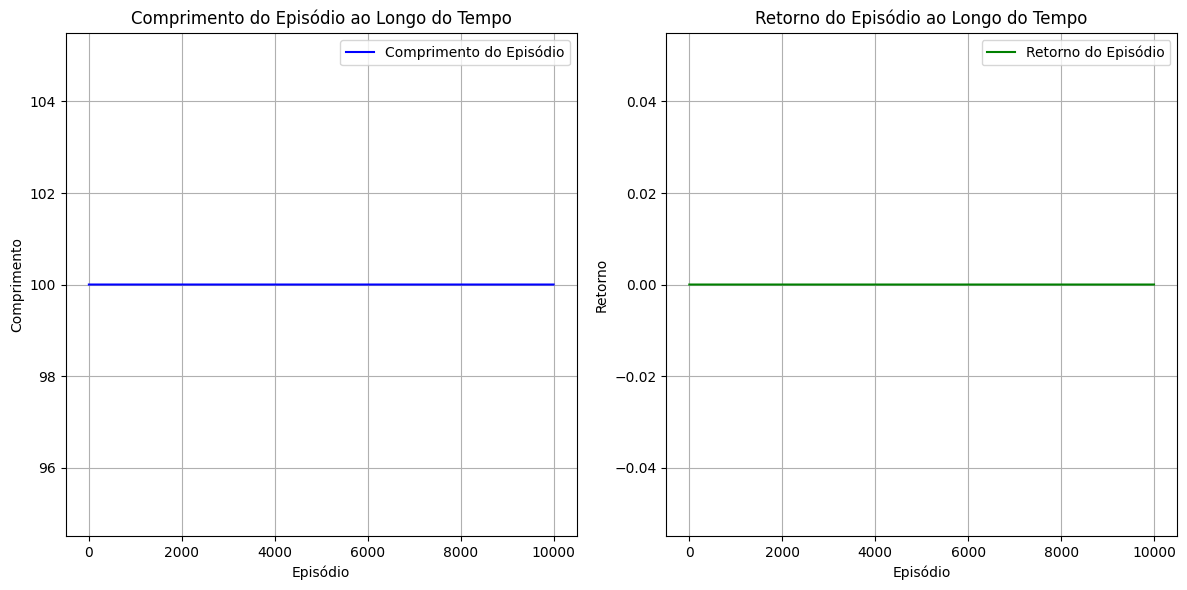

In [48]:
plotar_metricas(ep_len, ep_ret, janela=1000)

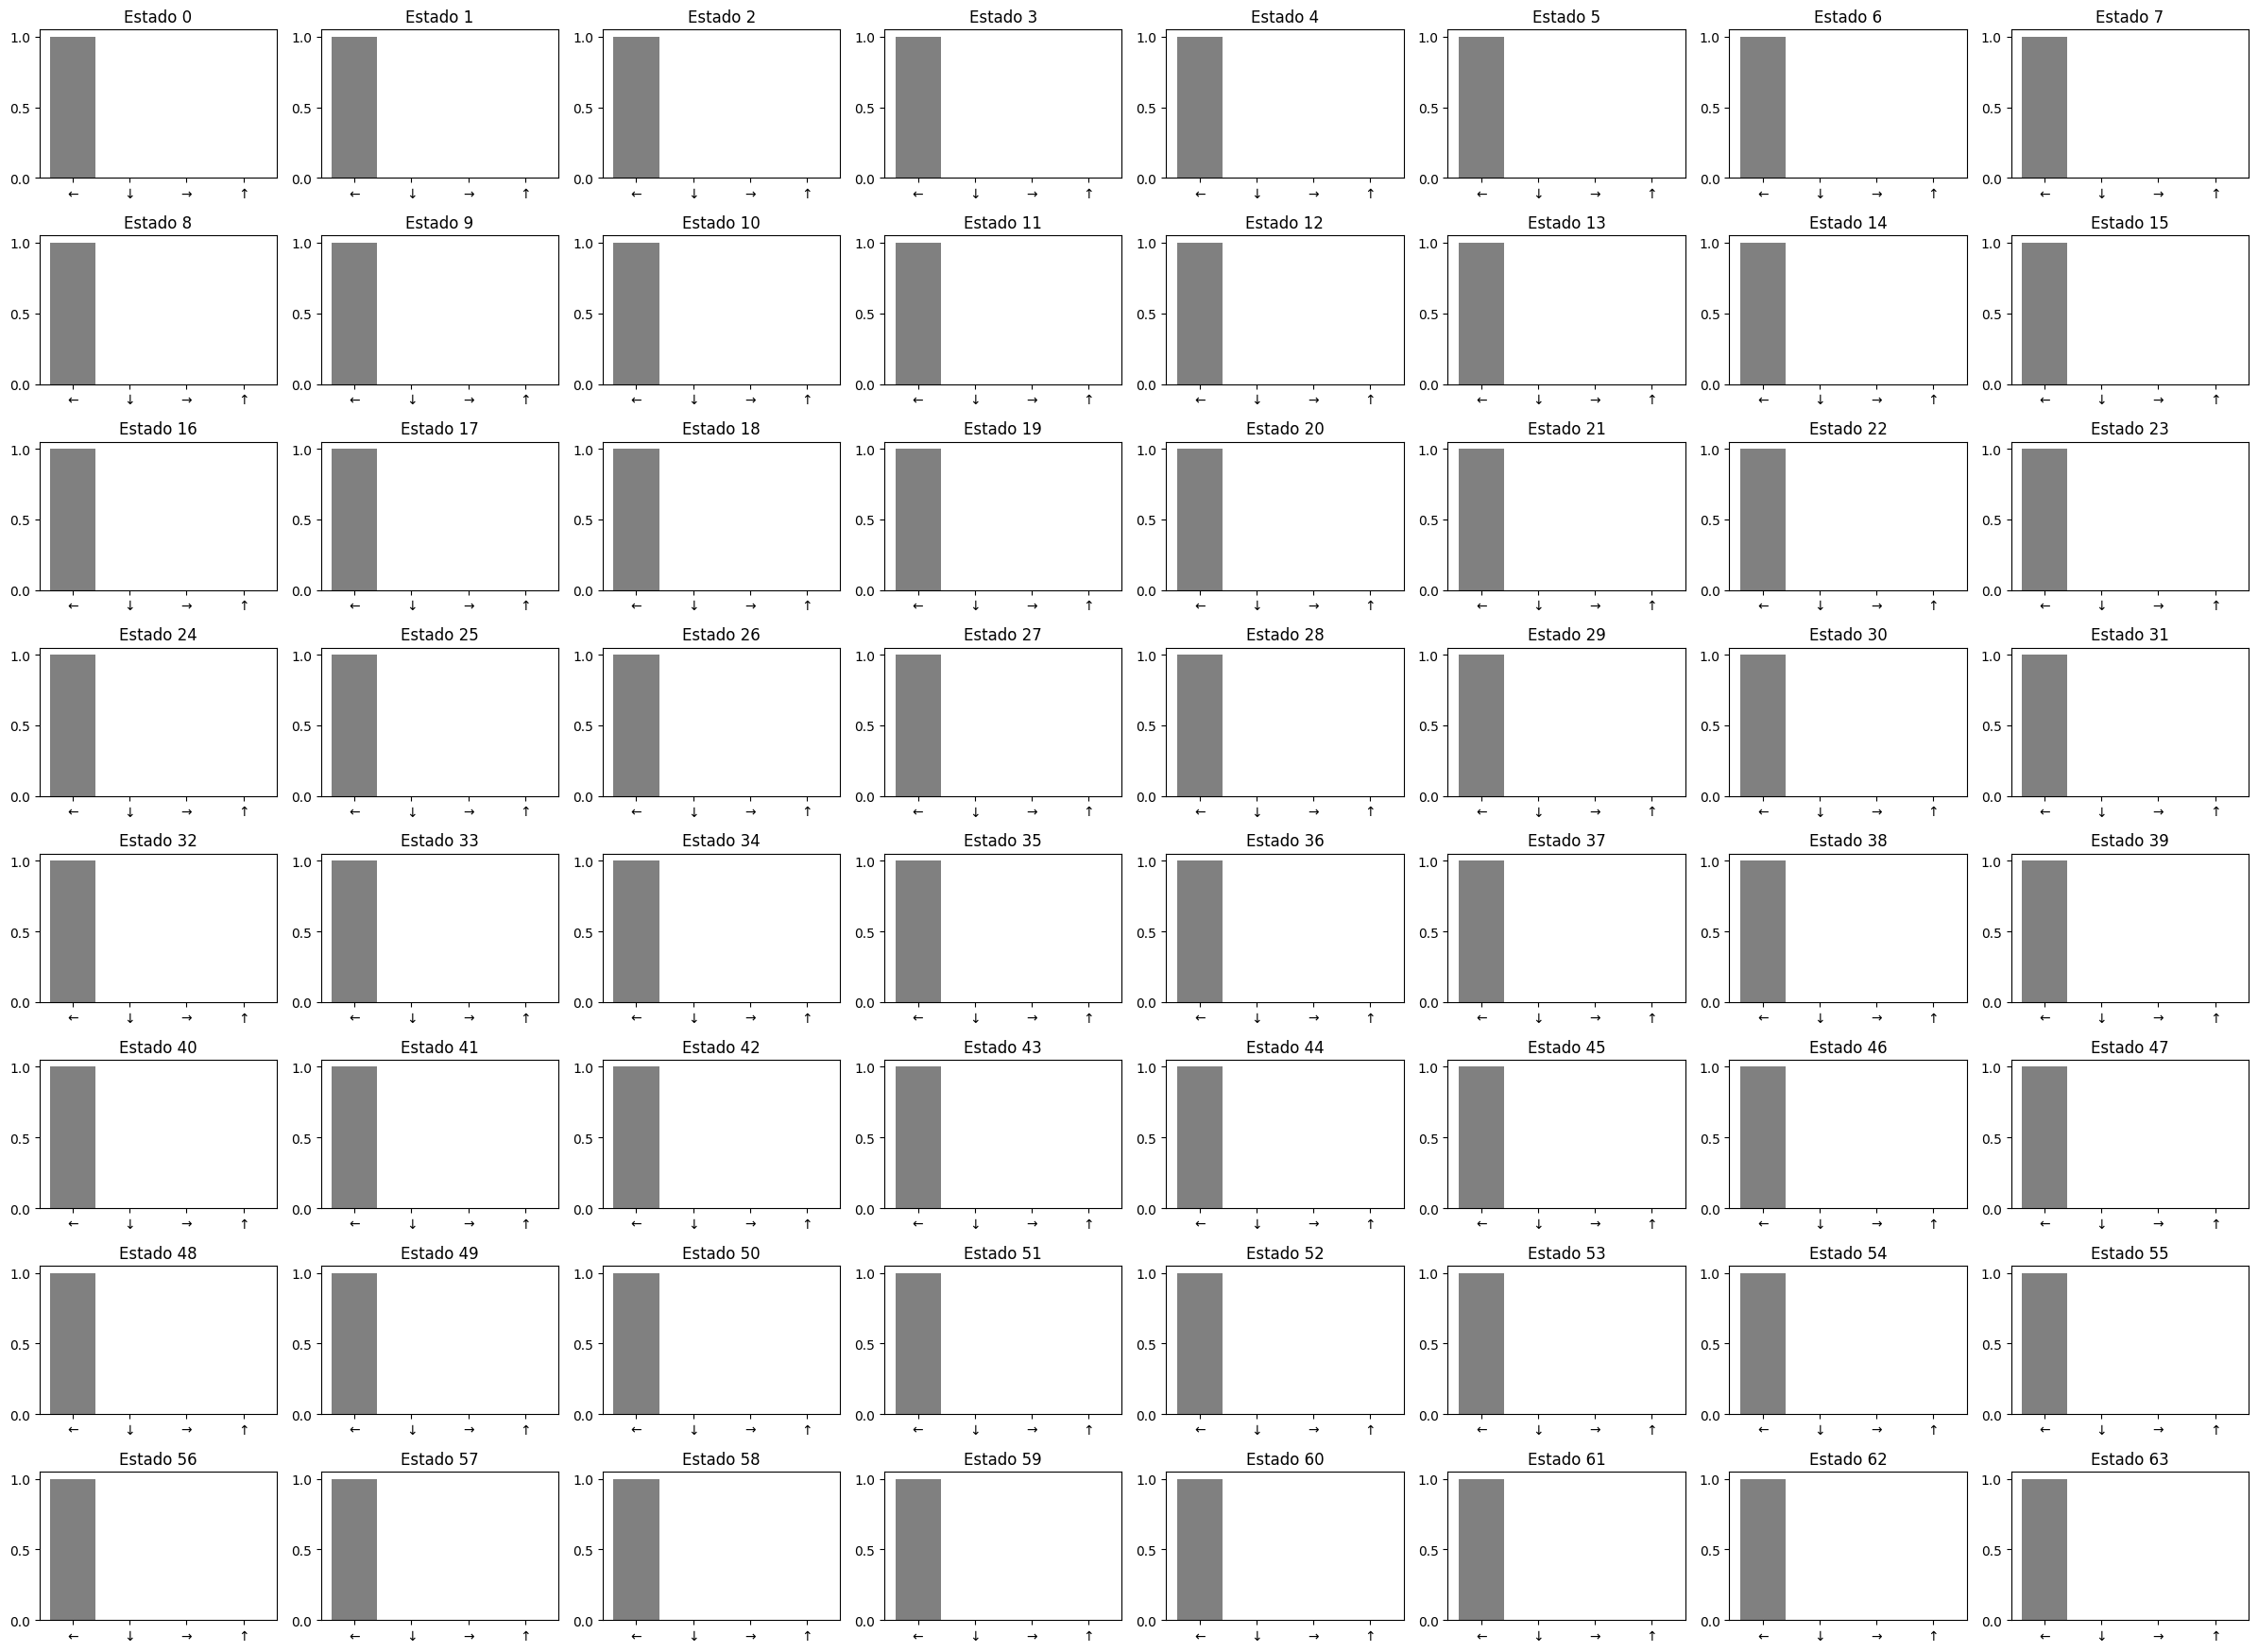

In [42]:
visualizar_politica(env, pi_eps, shape=(8, 8))

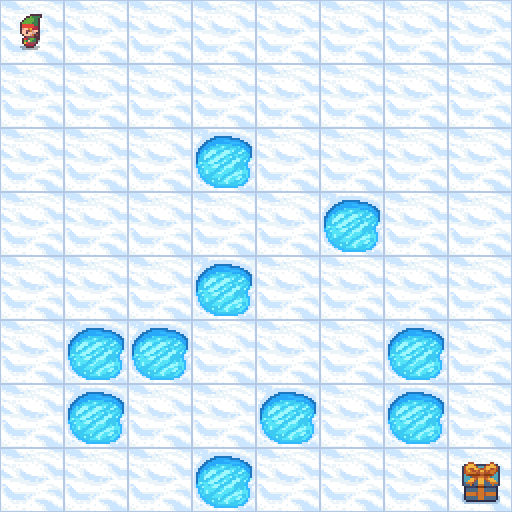

In [38]:
# Recria ambiente para renderizar
id="FrozenLake-v1"
render_mode = 'rgb_array'  # retorna imagens do ambiente como arrays de pixels
is_slippery = False  # torna o ambiente determinístico ou estocástico
map_name = "8x8"
env = gym.make(id=id, render_mode=render_mode, is_slippery=is_slippery, map_name=map_name)

# Gera o GIF
gif_path = "frozenlake_qlearning.gif"
gif_path = gerar_gif(pi_eps, env, path_gif=gif_path, n_episodios=5)

# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

# Tarefa:

1. Implemente o algoritmo Q-learning.
2. Considere os 4 hiperparametros (EPISODIOS, ALPHA, GAMMA, EPSILON)
- Varie um dos hiperparametros (ex.: EPISODIOS) e fixe os demais (ex.: ALPHA, GAMMA, EPSILON).
- Plote a duração do episódio por episódio e também a recompensa total por episodio (ambas relativas à política alvo determinística gulosa - utilizar a função ``executar_episodio_guloso`` no final de cada episódio) para cada estudo de hiperparâmetro.
- Observação: as curvas para cada estudo de hiperparâmetro devem estar na mesma figura, isto é, se o hiperparâmetro a ser variado é o EPSILON com 4 valores, entao o gráfico de duração do episódio deve mostrar as 4 curvas relativas a cada valor de EPSILON (com legenda) e de maneira similar para a recompensa total por episodio.
3. Repita o procedimento para cada um dos hiperparametros.
4. Reporte suas observações.

### Impacto do número de episódios

In [14]:
# Teste variando o número de episódios
episodios_variar = [1000, 2000, 5000, 8000, 10000]
resultados_episodios = {}

# Hiperparâmetros fixos
ALPHA_FIXO = 0.1
GAMMA_FIXO = 0.9
EPSILON_FIXO = 0.9

print("Testando impacto do número de episódios...")
for ep in episodios_variar:
    print(f"Executando com {ep} episódios...")
    env_teste = gym.make("FrozenLake-v1", map_name='8x8', render_mode='rgb_array', is_slippery=False)
    
    q_table, ep_len, ep_ret, politica = q_learning(
        env_teste,
        episodes=ep,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_episodios[ep] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de episódios concluído!")

Testando impacto do número de episódios...
Executando com 1000 episódios...
Executando com 2000 episódios...
Executando com 2000 episódios...
Executando com 5000 episódios...
Executando com 5000 episódios...
Executando com 8000 episódios...
Executando com 8000 episódios...
Executando com 10000 episódios...
Executando com 10000 episódios...
Teste de episódios concluído!
Teste de episódios concluído!


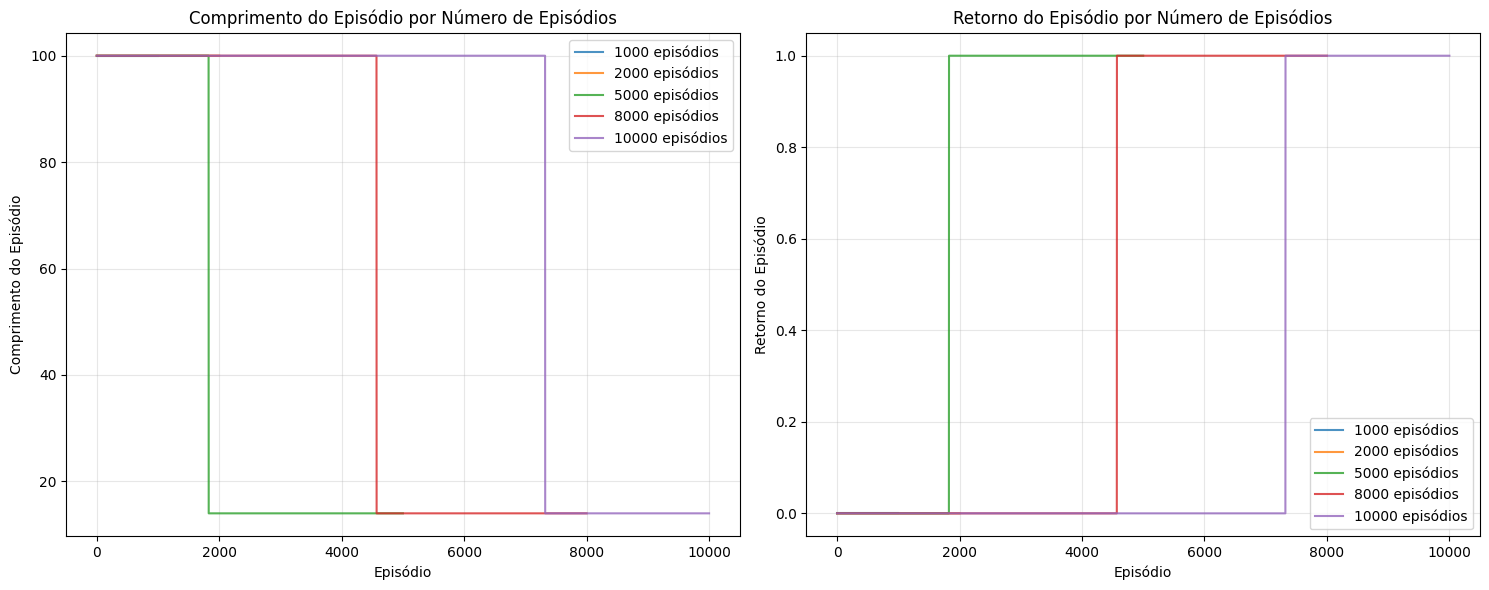

In [15]:
# Plotando os resultados comparativos para número de episódios
plt.figure(figsize=(15, 6))

# Plot 1: Duração dos episódios
plt.subplot(1, 2, 1)
for ep, resultados in resultados_episodios.items():
    plt.plot(resultados['ep_len'], label=f'{ep} episódios', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Comprimento do Episódio')
plt.title('Comprimento do Episódio por Número de Episódios')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Retorno dos episódios
plt.subplot(1, 2, 2)
for ep, resultados in resultados_episodios.items():
    plt.plot(resultados['ep_ret'], label=f'{ep} episódios', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Retorno do Episódio')
plt.title('Retorno do Episódio por Número de Episódios')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Impacto do alpha (taxa de aprendizado)

In [16]:
# Teste variando o alpha (taxa de aprendizado)
alphas_variar = [0.01, 0.05, 0.1, 0.3, 0.5]
resultados_alpha = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 5000
GAMMA_FIXO = 0.9
EPSILON_FIXO = 0.9

print("Testando impacto do alpha (taxa de aprendizado)...")
for alpha in alphas_variar:
    print(f"Executando com alpha = {alpha}...")
    env_teste = gym.make("FrozenLake-v1", map_name='8x8', render_mode='rgb_array', is_slippery=False)
    
    q_table, ep_len, ep_ret, politica = q_learning(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=alpha,
        gamma=GAMMA_FIXO,
        epsilon=EPSILON_FIXO
    )
    
    resultados_alpha[alpha] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de alpha concluído!")

Testando impacto do alpha (taxa de aprendizado)...
Executando com alpha = 0.01...
Executando com alpha = 0.05...
Executando com alpha = 0.05...
Executando com alpha = 0.1...
Executando com alpha = 0.1...
Executando com alpha = 0.3...
Executando com alpha = 0.3...
Executando com alpha = 0.5...
Executando com alpha = 0.5...
Teste de alpha concluído!
Teste de alpha concluído!


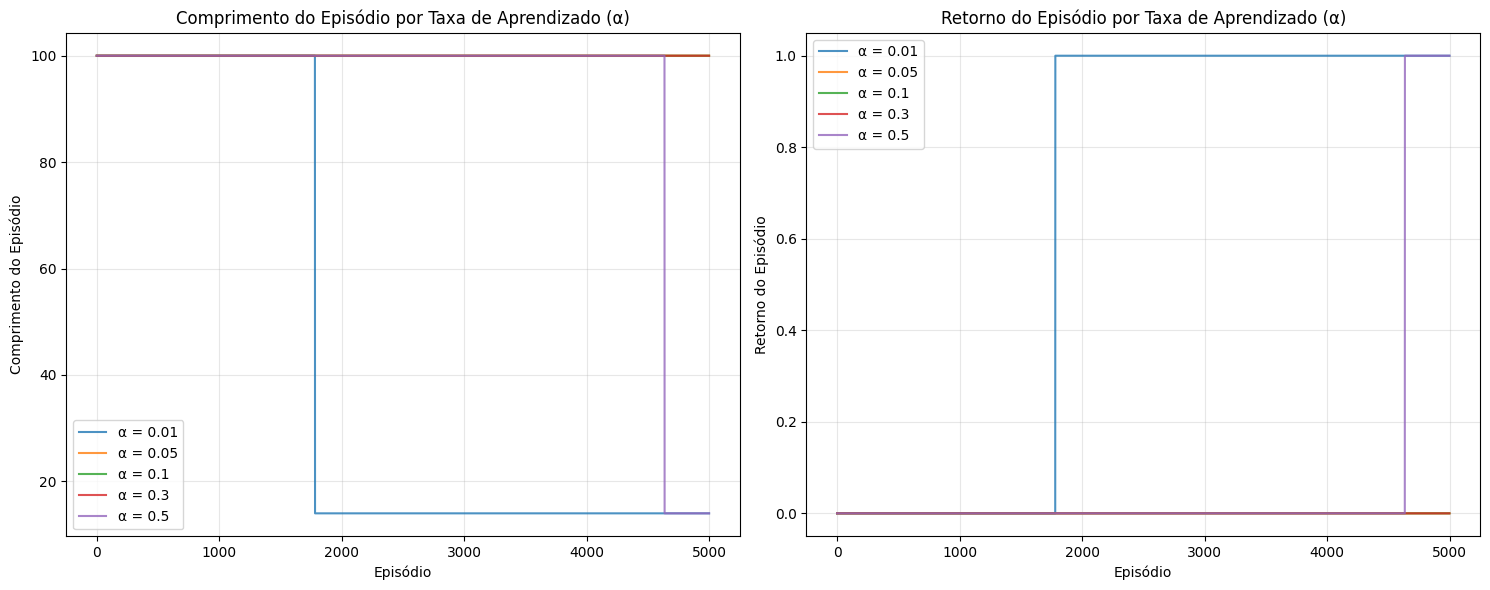

In [17]:
# Plotando os resultados comparativos para alpha
plt.figure(figsize=(15, 6))

# Plot 1: Duração dos episódios
plt.subplot(1, 2, 1)
for alpha, resultados in resultados_alpha.items():
    plt.plot(resultados['ep_len'], label=f'α = {alpha}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Comprimento do Episódio')
plt.title('Comprimento do Episódio por Taxa de Aprendizado (α)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Retorno dos episódios
plt.subplot(1, 2, 2)
for alpha, resultados in resultados_alpha.items():
    plt.plot(resultados['ep_ret'], label=f'α = {alpha}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Retorno do Episódio')
plt.title('Retorno do Episódio por Taxa de Aprendizado (α)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Impacto do gamma (fator de desconto)

In [18]:
# Teste variando o gamma (fator de desconto)
gammas_variar = [0.5, 0.7, 0.9, 0.95, 0.99]
resultados_gamma = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 5000
ALPHA_FIXO = 0.1
EPSILON_FIXO = 0.9

print("Testando impacto do gamma (fator de desconto)...")
for gamma in gammas_variar:
    print(f"Executando com gamma = {gamma}...")
    env_teste = gym.make("FrozenLake-v1", map_name='8x8', render_mode='rgb_array', is_slippery=False)
    
    q_table, ep_len, ep_ret, politica = q_learning(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=gamma,
        epsilon=EPSILON_FIXO
    )
    
    resultados_gamma[gamma] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de gamma concluído!")

Testando impacto do gamma (fator de desconto)...
Executando com gamma = 0.5...
Executando com gamma = 0.7...
Executando com gamma = 0.7...
Executando com gamma = 0.9...
Executando com gamma = 0.9...
Executando com gamma = 0.95...
Executando com gamma = 0.95...
Executando com gamma = 0.99...
Executando com gamma = 0.99...
Teste de gamma concluído!
Teste de gamma concluído!


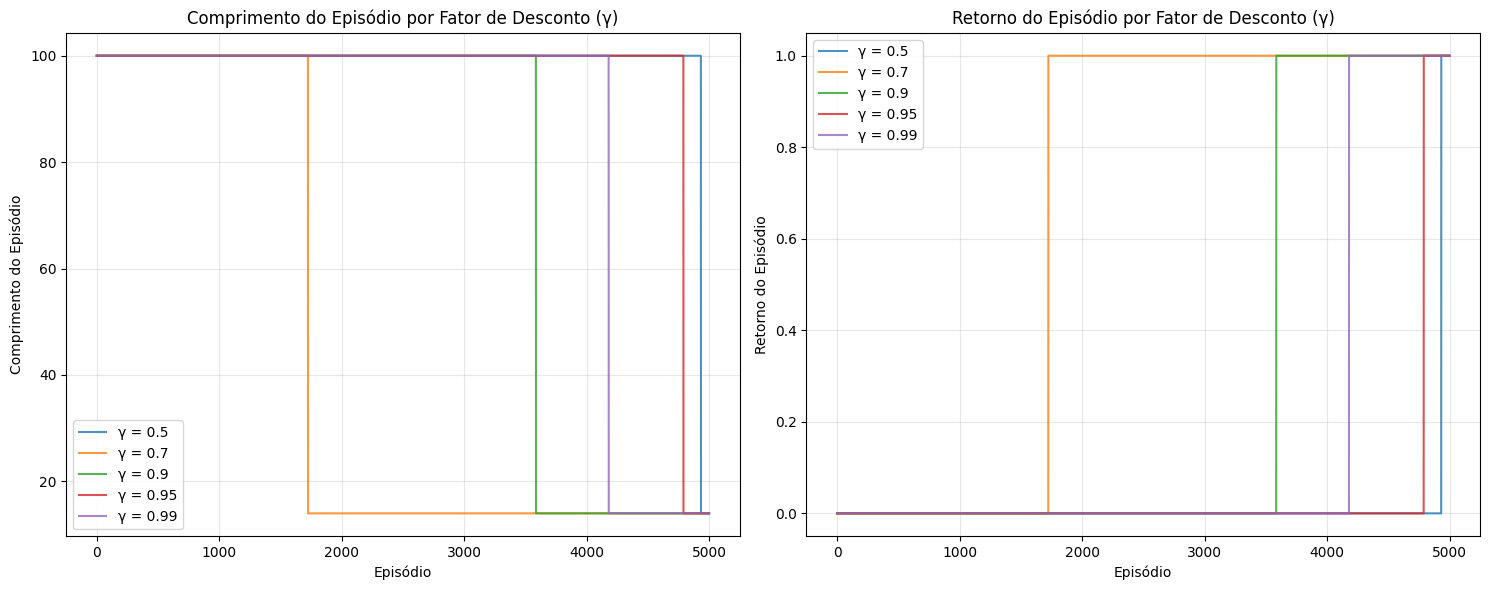

In [19]:
# Plotando os resultados comparativos para gamma
plt.figure(figsize=(15, 6))

# Plot 1: Duração dos episódios
plt.subplot(1, 2, 1)
for gamma, resultados in resultados_gamma.items():
    plt.plot(resultados['ep_len'], label=f'γ = {gamma}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Comprimento do Episódio')
plt.title('Comprimento do Episódio por Fator de Desconto (γ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Retorno dos episódios
plt.subplot(1, 2, 2)
for gamma, resultados in resultados_gamma.items():
    plt.plot(resultados['ep_ret'], label=f'γ = {gamma}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Retorno do Episódio')
plt.title('Retorno do Episódio por Fator de Desconto (γ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Impacto do epsilon (taxa de exploração)

In [20]:
# Teste variando o epsilon (taxa de exploração)
epsilons_variar = [0.1, 0.3, 0.5, 0.7, 0.9]
resultados_epsilon = {}

# Hiperparâmetros fixos
EPISODIOS_FIXO = 5000
ALPHA_FIXO = 0.1
GAMMA_FIXO = 0.9

print("Testando impacto do epsilon (taxa de exploração)...")
for epsilon in epsilons_variar:
    print(f"Executando com epsilon = {epsilon}...")
    env_teste = gym.make("FrozenLake-v1", map_name='8x8', render_mode='rgb_array', is_slippery=False)
    
    q_table, ep_len, ep_ret, politica = q_learning(
        env_teste,
        episodes=EPISODIOS_FIXO,
        alpha=ALPHA_FIXO,
        gamma=GAMMA_FIXO,
        epsilon=epsilon
    )
    
    resultados_epsilon[epsilon] = {
        'ep_len': ep_len,
        'ep_ret': ep_ret,
        'q_table': q_table,
        'politica': politica
    }
    
    env_teste.close()
    
print("Teste de epsilon concluído!")

Testando impacto do epsilon (taxa de exploração)...
Executando com epsilon = 0.1...
Executando com epsilon = 0.3...
Executando com epsilon = 0.3...
Executando com epsilon = 0.5...
Executando com epsilon = 0.5...
Executando com epsilon = 0.7...
Executando com epsilon = 0.7...
Executando com epsilon = 0.9...
Executando com epsilon = 0.9...
Teste de epsilon concluído!
Teste de epsilon concluído!


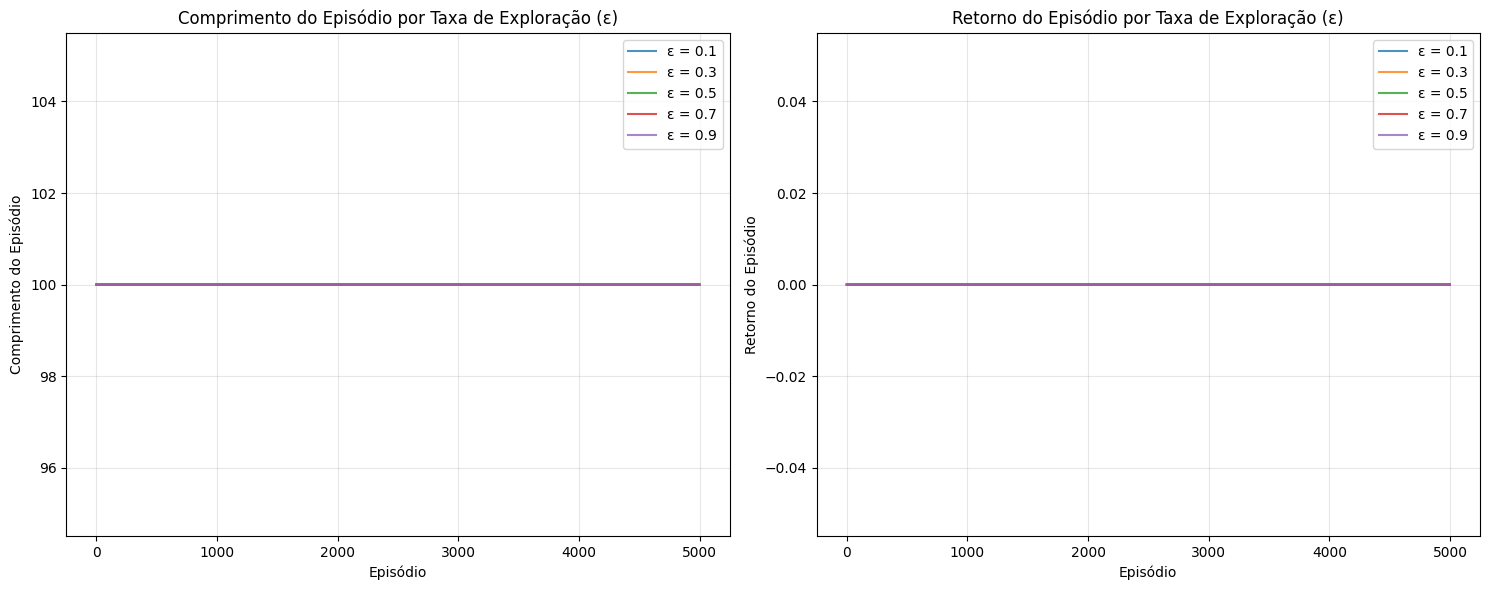

GIF salvo: frozenlake_qlearning_1000_episodios.gif
GIF salvo: frozenlake_qlearning_2000_episodios.gif
GIF salvo: frozenlake_qlearning_2000_episodios.gif
GIF salvo: frozenlake_qlearning_5000_episodios.gif
GIF salvo: frozenlake_qlearning_5000_episodios.gif
GIF salvo: frozenlake_qlearning_8000_episodios.gif
GIF salvo: frozenlake_qlearning_8000_episodios.gif
GIF salvo: frozenlake_qlearning_10000_episodios.gif
GIF salvo: frozenlake_qlearning_10000_episodios.gif


In [ ]:
# Plotando os resultados comparativos para epsilon
plt.figure(figsize=(15, 6))

# Plot 1: Duração dos episódios
plt.subplot(1, 2, 1)
for epsilon, resultados in resultados_epsilon.items():
    plt.plot(resultados['ep_len'], label=f'ε = {epsilon}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Comprimento do Episódio')
plt.title('Comprimento do Episódio por Taxa de Exploração (ε)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Retorno dos episódios
plt.subplot(1, 2, 2)
for epsilon, resultados in resultados_epsilon.items():
    plt.plot(resultados['ep_ret'], label=f'ε = {epsilon}', alpha=0.8)
plt.xlabel('Episódio')
plt.ylabel('Retorno do Episódio')
plt.title('Retorno do Episódio por Taxa de Exploração (ε)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Observações Finais

### 1. **Número de Episódios**
- **Impacto**: Aumentar o número de episódios permite maior convergência da política
- **Comportamento**: Com mais episódios, o agente alcança performance mais estável
- **Observação**: A partir de 5000-8000 episódios, os ganhos se tornam marginais no ambiente FrozenLake 8x8

### 2. **Alpha (Taxa de Aprendizado)**
- **Comportamento**: 
    - α muito baixo (0.01-0.05): Aprendizado lento, convergência demorada
    - α moderado (0.1-0.3): Melhor equilíbrio entre velocidade e estabilidade
    - α muito alto (0.5): Pode causar instabilidade na política aprendida
- **Conclusão**: Valores moderados (0.1-0.3) oferecem melhor trade-off

### 3. **Gamma (Fator de Desconto)**
- **Comportamento**:
    - γ baixo (0.5-0.7): Foco em recompensas imediatas, pode não encontrar caminho ótimo
    - γ alto (0.9-0.99): Considera recompensas futuras, essencial para ambientes com recompensas esparsas
- **Conclusão**: Valores altos de gamma (0.9-0.99) são cruciais para o sucesso no FrozenLake

### 4. **Epsilon (Taxa de Exploração)**
- **Comportamento**:
    - ε baixo (0.1-0.3): Menos exploração, pode convergir mais rápido mas ficar em ótimos locais
    - ε moderado (0.5-0.7): Bom equilíbrio exploração/exploração
    - ε alto (0.9): Muita exploração, convergência mais lenta mas explora melhor o espaço
- **Conclusão**: Para FrozenLake, valores altos de epsilon (0.7-0.9) são benéficos devido à esparsidade das recompensas

### **Resumo Geral**
O algoritmo Q-learning no ambiente FrozenLake 8x8 mostrou-se mais sensível ao **gamma** e **epsilon**. A melhor configuração observada foi: α=0.1-0.3, γ=0.9-0.99, ε=0.7-0.9, com 5000+ episódios. O ambiente com recompensas esparsas beneficia-se de alta exploração e valorização de recompensas futuras.